---
title: "Cross-gradient Joint Inversion of Gravity and Magnetic Anomaly Data"
authors:
  - id: devincowan
---

In [1]:
%matplotlib inline

Here we simultaneously invert gravity and magentic data using cross-gradient
constraint. The recovered density and susceptibility models are supposed to have
structural similarity. For this tutorial, we focus on the following:

    - Defining the survey from xyz formatted data
    - Generating a mesh based on survey geometry
    - Including surface topography
    - Defining the inverse problem via combmaps (2 data misfit terms,
        2 regularization terms, a coupling term and optimization)
    - Specifying directives for the inversion
    - Plotting the recovered model and data misfit


Although we consider gravity and magnetic anomaly data in this tutorial,
the same approach can be used to invert gradiometry and other types of geophysical data.


## Import modules




In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh
from discretize.utils import active_from_xyz
from simpeg.utils import plot2Ddata
from simpeg.potential_fields import gravity, magnetics
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

## Define File Names

File paths for assets we are loading. To set up the inversion, we require
topography and field observations. The true model defined on the whole mesh
is loaded to compare with the inversion result. These files are stored as a
tar-file on our google cloud bucket:
"https://storage.googleapis.com/simpeg/doc-assets/gravity.tar.gz"



In [3]:
# # storage bucket where we have the data
data_source = (
    "https://storage.googleapis.com/simpeg/doc-assets/cross_gradient_data.tar.gz"
)

# # download the data
downloaded_data = utils.download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "topo.txt"
model_filename = dir_path + "true_model.txt"

overwriting /home/ssoler/git/user-tutorials/notebooks/11-joint-inversion/cross_gradient_data.tar.gz
   saved to: /home/ssoler/git/user-tutorials/notebooks/11-joint-inversion/cross_gradient_data.tar.gz
Download completed!


## Load Data and Plot

Here we load and plot synthetic gravity anomaly data. Topography is generally
defined as an (N, 3) array. Gravity data is generally defined with 4 columns:
x, y, z and data.




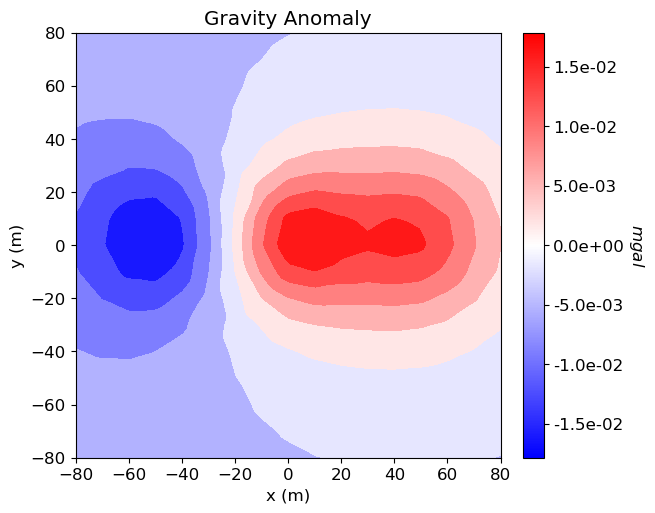

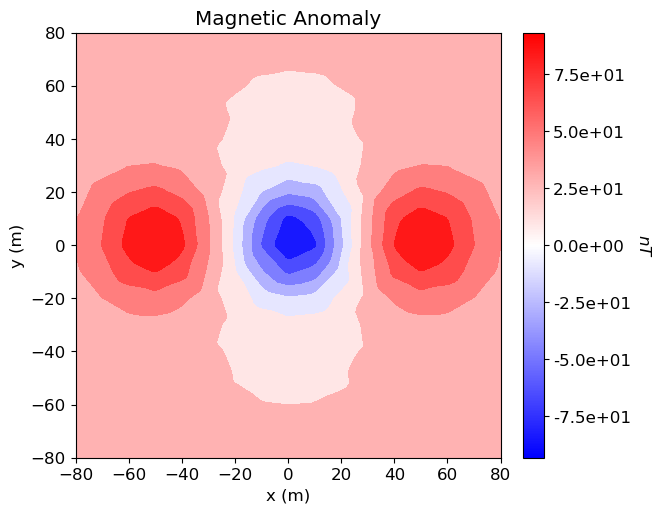

In [4]:
# Load topography
xyz_topo = np.loadtxt(topo_filename)

# Load field data
dobs_grav = np.loadtxt(dir_path + "gravity_data.obs")
dobs_mag = np.loadtxt(dir_path + "magnetic_data.obs")

# Define receiver locations and observed data
receiver_locations = dobs_grav[:, 0:3]

dobs_grav = dobs_grav[:, -1]
dobs_mag = dobs_mag[:, -1]

# Plot
mpl.rcParams.update({"font.size": 12})

# gravity data
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs_grav, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Gravity Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.8, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(
    vmin=-np.max(np.abs(dobs_grav)), vmax=np.max(np.abs(dobs_grav))
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

# magnetic data
fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs_mag, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Magnetic Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.8, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(
    vmin=-np.max(np.abs(dobs_mag)), vmax=np.max(np.abs(dobs_mag))
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()

## Assign Uncertainties

Inversion with SimPEG requires that we define standard deviation on our data.
This represents our estimate of the noise in our data. For gravity inversion,
a constant floor value is generally applied to all data. For this tutorial,
the standard deviation on each datum will be 1% of the maximum observed
gravity anomaly value. For magnetic inversion, the same strategy is performed.




In [5]:
maximum_anomaly_grav = np.max(np.abs(dobs_grav))
uncertainties_grav = 0.01 * maximum_anomaly_grav * np.ones(np.shape(dobs_grav))

maximum_anomaly_mag = np.max(np.abs(dobs_mag))
uncertainties_mag = 0.01 * maximum_anomaly_mag * np.ones(np.shape(dobs_mag))

## Defining the Survey

Here, we define survey that will be used for this tutorial. Gravity
surveys are simple to create. The user only needs an (N, 3) array to define
the xyz locations of the observation locations. From this, the user can
define the receivers and the source field.




In [6]:
# Define the receivers. The data consist of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_grav = gravity.receivers.Point(receiver_locations, components="gz")

# Define the source field and survey for gravity data
source_field_grav = gravity.sources.SourceField(receiver_list=[receiver_grav])
survey_grav = gravity.survey.Survey(source_field_grav)


# Define the component(s) of the field we want to simulate as a list of strings.
# Here we simulation total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_mag = magnetics.receivers.Point(receiver_locations, components=components)

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = 90
declination = 0
strength = 50000

# Define the source field and survey for gravity data
source_field_mag = magnetics.sources.UniformBackgroundField(
    receiver_list=[receiver_mag],
    amplitude=strength,
    declination=declination,
    inclination=inclination,
)
survey_mag = magnetics.survey.Survey(source_field_mag)

## Defining the Data

Here is where we define the data that are inverted. The data are defined by
the survey, the observation values and the standard deviation.




In [7]:
data_object_grav = data.Data(
    survey_grav, dobs=dobs_grav, standard_deviation=uncertainties_grav
)
data_object_mag = data.Data(
    survey_mag, dobs=dobs_mag, standard_deviation=uncertainties_mag
)

## Defining a Tensor Mesh

Here, we create the tensor mesh that will be used to invert gravity anomaly
data. If desired, we could define an OcTree mesh.




In [8]:
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

## Starting/Reference Model and Mapping on Tensor Mesh

Here, we create starting and/or reference models for the inversion as
well as the mapping from the model space to the active cells. Starting and
reference models can be a constant background value or contain a-priori
structures. Here, the backgrounds are 1e-6 g/cc and 1e-6 SI for density and
susceptibility models, respectively. Note that the background values could
be different for density and susceptibility models.




In [9]:
# Define density contrast values for each unit in g/cc.
background_dens, background_susc = 1e-6, 1e-6

# Find the indicies of the active cells in forward model (ones below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model consists of a value for each active cell

# Create Wires Map that maps from stacked models to individual model components
# m1 refers to density model, m2 refers to susceptibility
wires = maps.Wires(("density", nC), ("susceptibility", nC))

# Define and plot starting model
starting_model = np.r_[background_dens * np.ones(nC), background_susc * np.ones(nC)]

## Define the Physics

Here, we define the physics of the gravity and magnetic problems by using the simulation
class.




In [10]:
simulation_grav = gravity.simulation.Simulation3DIntegral(
    survey=survey_grav,
    mesh=mesh,
    rhoMap=wires.density,
    active_cells=ind_active,
    engine="choclo",
)

simulation_mag = magnetics.simulation.Simulation3DIntegral(
    survey=survey_mag,
    mesh=mesh,
    model_type="scalar",
    chiMap=wires.susceptibility,
    active_cells=ind_active,
    engine="choclo",
)

## Define the Inverse Problem

The inverse problem is defined by 4 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Coupling: a connection of two different physical property models
    4) Optimization: the numerical approach used to solve the inverse problem




In [11]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis_grav = data_misfit.L2DataMisfit(data=data_object_grav, simulation=simulation_grav)
dmis_mag = data_misfit.L2DataMisfit(data=data_object_mag, simulation=simulation_mag)

# Define the regularization (model objective function).
reg_grav = regularization.WeightedLeastSquares(
    mesh, active_cells=ind_active, mapping=wires.density
)
reg_mag = regularization.WeightedLeastSquares(
    mesh, active_cells=ind_active, mapping=wires.susceptibility
)

# Define the coupling term to connect two different physical property models
lamda = 2e12  # weight for coupling term
cross_grad = regularization.CrossGradient(mesh, wires, active_cells=ind_active)

# combo
dmis = dmis_grav + dmis_mag
reg = reg_grav + reg_mag + lamda * cross_grad

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=10,
    lower=-2.0,
    upper=2.0,
    maxIterLS=20,
    maxIterCG=100,
    tolCG=1e-3,
    tolX=1e-3,
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define Inversion Directives

Here we define any directiveas that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.




In [12]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.PairedBetaEstimate_ByEig(beta0_ratio=1e0)
# starting_beta.n_pw_iter = 10

# Defining the fractional decrease in beta and the number of Gauss-Newton solves
# for each beta value.
beta_schedule = directives.PairedBetaSchedule(cooling_factor=5, cooling_rate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SimilarityMeasureSaveOutputEveryIteration(save_txt=False)

joint_inv_dir = directives.SimilarityMeasureInversionDirective()

stopping = directives.MovingAndMultiTargetStopping(tol=1e-6)

sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()


# The directives are defined as a list.
directives_list = [
    joint_inv_dir,
    sensitivity_weights,
    stopping,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
]

## Running the Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [13]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    


model has any nan: 0
============================================================ Projected GNCG ============================================================
  #            betas             lambda      f               phi_d                     phi_m            phi_sim    iterCG    Comment   
---------------------------------------------------------------------------------------------------------------------------------------
x0 has any nan: 0


   0  ['8.42e+04', '3.23e+04']  2.00e+12  4.55e+05             []                        []             0.00e+00      0                


   1  ['1.68e+04', '6.46e+03']  2.00e+12  2.24e+04  ['1.30e+04', '3.31e+02']  ['3.75e-01', '1.64e-01']  8.88e-10    100                


   2  ['3.37e+03', '8.61e+03']  2.00e+12  8.46e+03  ['3.41e+03', '9.47e+01']  ['5.84e-01', '1.74e-01']  7.48e-10    100     Skip BFGS  


   3  ['6.73e+02', '1.15e+04']  2.00e+12  5.29e+03  ['1.55e+03', '5.73e+01']  ['7.34e-01', '1.72e-01']  6.10e-10    100     Skip BFGS  


   4  ['1.35e+02', '1.53e+04']  2.00e+12  4.78e+03  ['1.01e+03', '6.85e+01']  ['8.03e-01', '1.68e-01']  5.05e-10    100     Skip BFGS  


   5  ['2.69e+01', '2.04e+04']  2.00e+12  5.09e+03  ['7.78e+02', '9.53e+01']  ['8.62e-01', '1.64e-01']  4.21e-10    100                


   6  ['5.39e+00', '2.72e+04']  2.00e+12  5.85e+03  ['6.33e+02', '1.26e+02']  ['8.86e-01', '1.61e-01']  3.49e-10    100                


   7  ['1.08e+00', '3.55e+04']  2.00e+12  6.91e+03  ['5.42e+02', '2.22e+02']  ['9.23e-01', '1.55e-01']  3.16e-10    100                


   8  ['2.16e-01', '7.10e+03']  2.00e+12  2.38e+03  ['4.74e+02', '3.24e+02']  ['9.32e-01', '1.51e-01']  2.55e-10    100                


   9  ['4.31e-02', '9.47e+03']  2.00e+12  2.49e+03  ['3.73e+02', '3.84e+01']  ['9.64e-01', '1.66e-01']  2.53e-10    100                


  10  ['8.62e-03', '1.26e+04']  2.00e+12  2.90e+03  ['3.53e+02', '5.55e+01']  ['9.73e-01', '1.64e-01']  2.09e-10    100                
------------------------- STOP! -------------------------
1 : maxIter   =      10    <= iter          =     10
------------------------- DONE! -------------------------


## Plotting True Model and Recovered Model




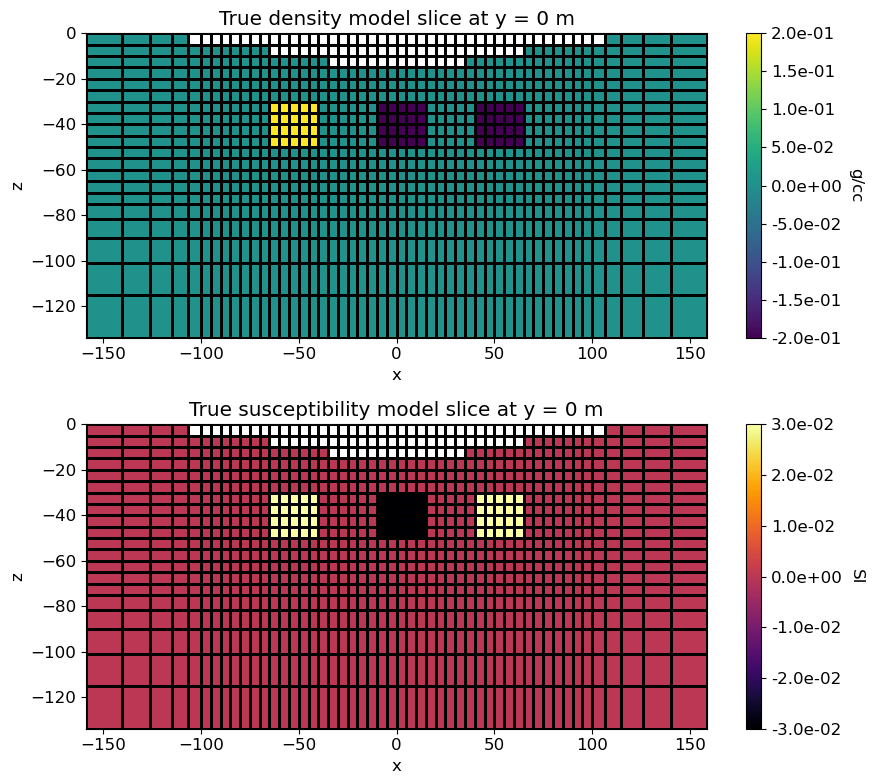

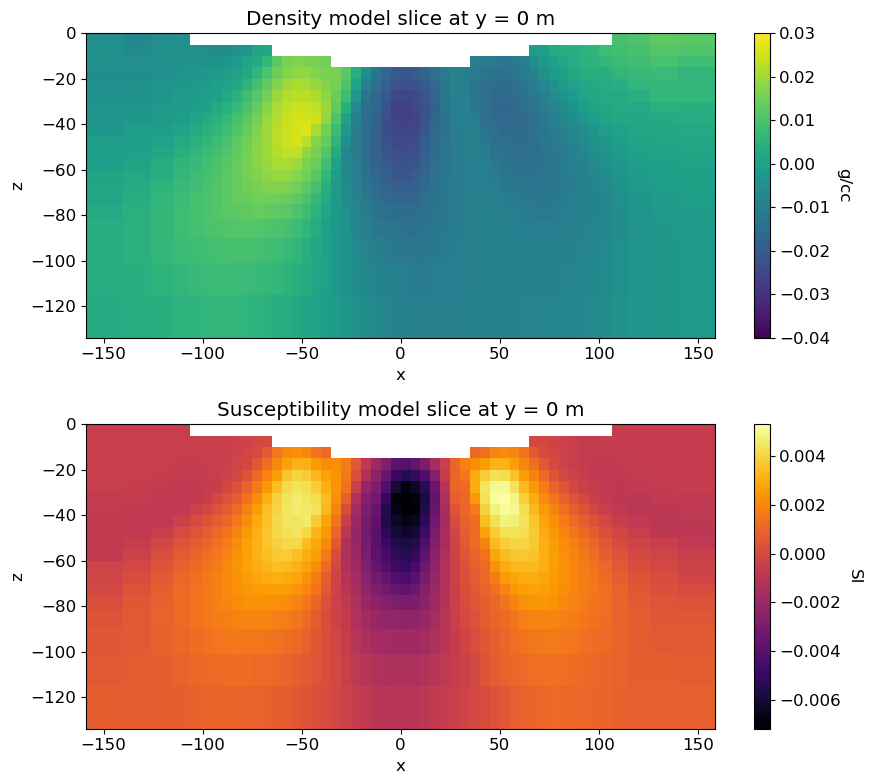

In [14]:
# Load the true model (was defined on the whole mesh) and extract only the
# values on active cells.

true_model_dens = np.loadtxt(dir_path + "true_model_dens.txt")
true_model_dens[~ind_active] = np.nan

true_model_susc = np.loadtxt(dir_path + "true_model_susc.txt")
true_model_susc[~ind_active] = np.nan

# Plot True Model
fig = plt.figure(figsize=(9, 8))
ax1 = plt.subplot(211)

(im,) = mesh.plot_slice(true_model_dens, normal="Y", ax=ax1, grid=True)
ax1.set_title("True density model slice at y = 0 m")
cbar = plt.colorbar(im, format="%.1e")
cbar.set_label("g/cc", rotation=270, labelpad=15, size=12)

ax2 = plt.subplot(212)
(im,) = mesh.plot_slice(
    true_model_susc, normal="Y", ax=ax2, grid=True, pcolor_opts={"cmap": "inferno"}
)

ax2.set_title("True susceptibility model slice at y = 0 m")
cbar = plt.colorbar(im, format="%.1e")
cbar.set_label("SI", rotation=270, labelpad=15, size=12)
plt.tight_layout()
plt.show()

# Plot Recovered Model
m_dens_joint, m_susc_joint = wires * recovered_model
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

fig = plt.figure(figsize=(9, 8))
ax1 = plt.subplot(211)
(im,) = mesh.plot_slice(
    plotting_map * m_dens_joint,
    normal="Y",
    ax=ax1,
    clim=(-0.04, 0.03),
)
ax1.set_title("Density model slice at y = 0 m")
cbar = plt.colorbar(im)
cbar.set_label("g/cc", rotation=270, labelpad=15, size=12)

ax2 = plt.subplot(212)
(im,) = mesh.plot_slice(
    plotting_map * m_susc_joint, normal="Y", ax=ax2, pcolor_opts={"cmap": "inferno"}
)
ax2.set_title("Susceptibility model slice at y = 0 m")
cbar = plt.colorbar(im)
cbar.set_label("SI", rotation=270, labelpad=15, size=12)

plt.tight_layout()
plt.show()

## Comparing jointly and separatly recovered models




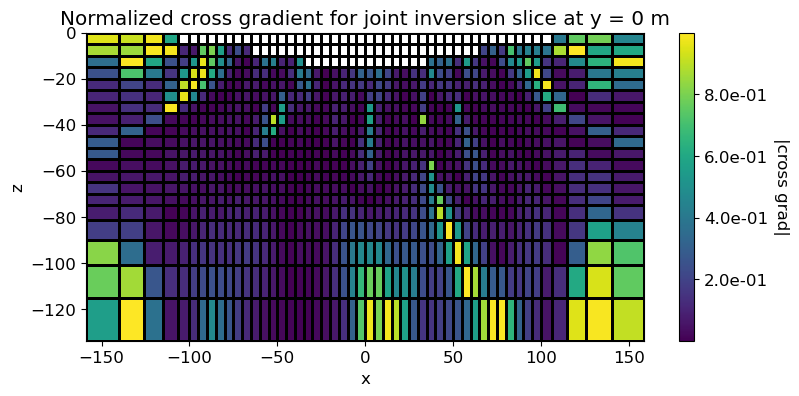

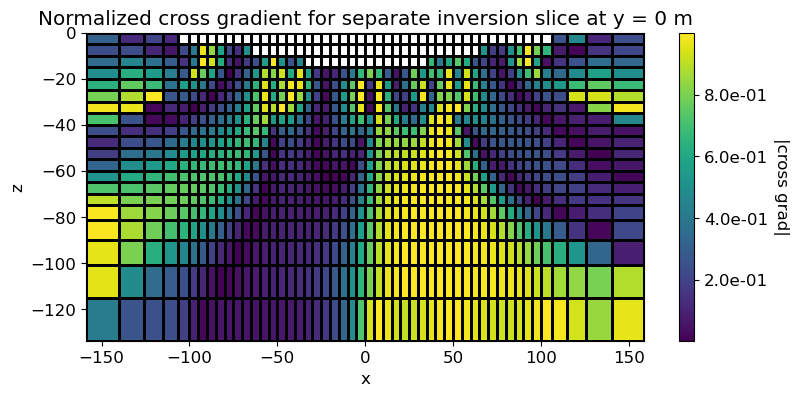

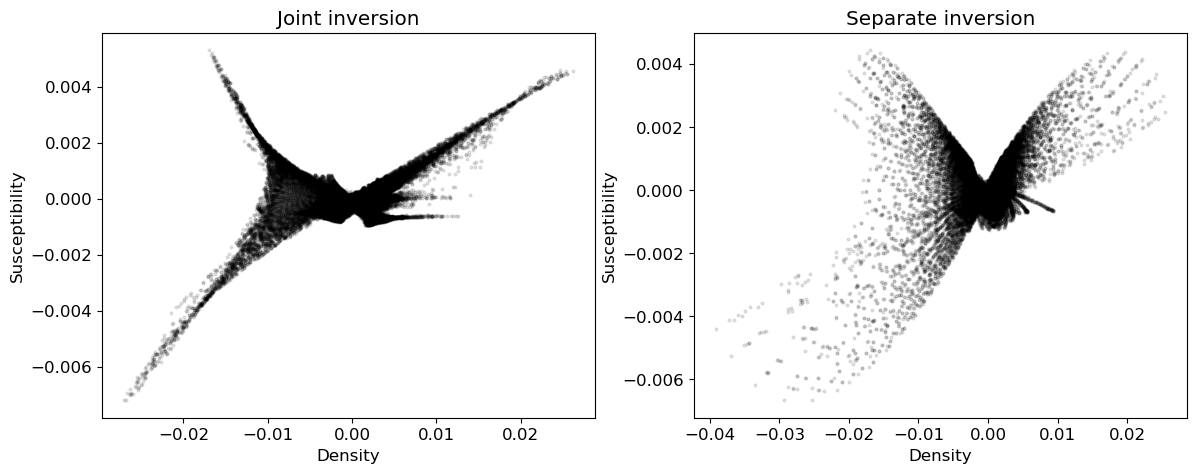

In [15]:
# Normalized Cross Gradient of Jointly Recovered Susceptibility and Density Models
ncg = cross_grad.calculate_cross_gradient(recovered_model, normalized=True)

fig = plt.figure(figsize=(9, 4))
ax = plt.subplot(111)
(im,) = mesh.plot_slice(
    plotting_map * ncg,
    normal="Y",
    ax=ax,
    grid=True,
)
ax.set_title("Normalized cross gradient for joint inversion slice at y = 0 m")
cbar = plt.colorbar(im, format="%.1e")
cbar.set_label("|cross grad|", rotation=270, labelpad=15, size=12)
plt.show()

# Normalized Cross Gradient of Separately Recovered Susceptibility and Density Models
m_dens_single = np.loadtxt(dir_path + "single_model_dens.txt")
m_susc_single = np.loadtxt(dir_path + "single_model_susc.txt")
m_separate = np.r_[m_dens_single[ind_active], m_susc_single[ind_active]]

ncg_single = cross_grad.calculate_cross_gradient(m_separate, normalized=True)

fig = plt.figure(figsize=(9, 4))
ax = plt.subplot(111)
(im,) = mesh.plot_slice(
    plotting_map * ncg_single,
    normal="Y",
    ax=ax,
    grid=True,
)
ax.set_title("Normalized cross gradient for separate inversion slice at y = 0 m")
cbar = plt.colorbar(im, format="%.1e")
cbar.set_label("|cross grad|", rotation=270, labelpad=15, size=12)

plt.show()


# Cross Plots Recovered Susceptibility and Density Models
fig = plt.figure(figsize=(14, 5))
ax0 = plt.subplot(121)
ax0.scatter(
    plotting_map * m_dens_joint, plotting_map * m_susc_joint, s=4, c="black", alpha=0.1
)

ax0.set_xlabel("Density", size=12)
ax0.set_ylabel("Susceptibility", size=12)
ax0.tick_params(labelsize=12)
ax0.set_title("Joint inversion")

ax1 = plt.subplot(122)
ax1.scatter(m_dens_single, m_susc_single, s=4, c="black", alpha=0.1)

ax1.set_xlabel("Density", size=12)
ax1.set_ylabel("Susceptibility", size=12)
ax1.tick_params(labelsize=12)
ax1.set_title("Separate inversion")

plt.show()